Accedemos al drive que tiene las rutas de train y test; se crean los generadores que cargan las imagenes en 280x280 y se reescalan en rango de [0,1].

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = "/content/drive/MyDrive/Proyecto1/Numbers/Train"
TEST_DIR  = "/content/drive/MyDrive/Proyecto1/Numbers/Test"

IMG_SIZE = (280, 280)
BATCH_SIZE = 32

datagen = ImageDataGenerator(rescale=1./255)

#train
train_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True
)

#test
test_generator = datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=1,
    shuffle=False
)

print("Clases detectadas:", train_generator.class_indices)


Mounted at /content/drive
Found 7100 images belonging to 10 classes.
Found 2064 images belonging to 10 classes.
Clases detectadas: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9}


Aquí se crea un ImageDataGenerator con split de 0.2 y se crean los
generadores de entrenamiento y validación para separar los datos.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models


TRAIN_DIR = "/content/drive/MyDrive/Proyecto1/Numbers/Train"
IMG_SIZE = (280, 280)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.20    #split train
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    subset="training",
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    subset="validation",
    shuffle=False
)

Found 5685 images belonging to 10 classes.
Found 1415 images belonging to 10 classes.


Se define el modelo base de CNN con varias capas Conv2D+MaxPooling y
capas densas finales, se compila con Adam y se entrena usando train/validation.
El CNN secuencial recibe imágenes en escala de grises de 280x280x1 y las procesa mediante tres bloques Conv2D y MaxPooling2D y luego de capas dense.
Cada bloque utiliza convoluciones con kernels de 5x5 con 32, 64 y 128 filtros, y con esto se va reduciendo el tamaño espacial.
Luego con un Flatten transforma el tensor de 35x35x128 en un vector de 156800 elementos, que alimentan un dense de 256 neuronas con ReLU y regularizacion L2 y una capa de salida softmax de 10 neuronas para clasificar los digitos de 0 a 9.
Se entrena el modelo con las imagenes normalizadas, y con un imagedatagenerator separa en train y validation 80/20 al igual que con un Adam y una funcion de perdida categorical_crossentropy. Este modelo sirvió como punto de partida y alcanzó una val_accuracy máxima de 0.7993.

In [ ]:
#CNN
model_cnn = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', padding='same',
                  input_shape=(280, 280, 1)),
    layers.MaxPooling2D((2,2)),


    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

model_cnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_cnn.summary()

EPOCHS = 10

history_cnn = model_cnn.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 280, 280, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 140, 140, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 140, 140, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 70, 70, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 70, 70, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 35, 35, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 156800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    40,141,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,236,298 (153.49 MB)

 Trainable params: 40,236,298 (153.49 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 2412s 14s/step - accuracy: 0.2747 - loss: 2.6332 - val_accuracy: 0.6862 - val_loss: 1.1108
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 69s 386ms/step - accuracy: 0.7707 - loss: 0.7577 - val_accuracy: 0.7498 - val_loss: 0.9709
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 67s 374ms/step - accuracy: 0.8758 - loss: 0.4196 - val_accuracy: 0.7682 - val_loss: 0.9626
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 67s 378ms/step - accuracy: 0.9139 - loss: 0.2829 - val_accuracy: 0.7696 - val_loss: 1.1283
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 69s 386ms/step - accuracy: 0.9394 - loss: 0.2093 - val_accuracy: 0.7837 - val_loss: 1.2334
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 69s 385ms/step - accuracy: 0.9463 - loss: 0.1835 - val_accuracy: 0.7710 - val_loss: 1.2729
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 67s 375ms/step - accuracy: 0.9614 - loss: 0.1327 - val_accuracy: 0.7781 - val_loss: 1.3302
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 69s 388ms/step - accuracy: 0.9603 - loss: 0

En el modelo_A reduje la complejidad bajando los filtros (16, 32 y 64) y cambiando la capa densa a 128 neuronas para ver si una red más pequeña conservaba buen rendimiento. Todo lo demás se mantuvo igual. El resultado bajó un poco, con una val_accuracy de 0.7661, mostrando que recortar demasiado sí afecta el desempeño.


In [ ]:
#Modelo 2
#Menos filtros (16, 32, 64)
from tensorflow.keras import layers, models

model_A = models.Sequential([
    layers.Conv2D(16, (3,3), activation='relu', padding='same',
                  input_shape=(280, 280, 1)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model_A.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_A = model_A.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)


Epoch 1/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 80s 407ms/step - accuracy: 0.3624 - loss: 2.1667 - val_accuracy: 0.6905 - val_loss: 1.2236
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 66s 371ms/step - accuracy: 0.8378 - loss: 0.5732 - val_accuracy: 0.7336 - val_loss: 1.0669
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 67s 375ms/step - accuracy: 0.9273 - loss: 0.2500 - val_accuracy: 0.7548 - val_loss: 1.3745
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 68s 385ms/step - accuracy: 0.9749 - loss: 0.1043 - val_accuracy: 0.7633 - val_loss: 1.4125
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 66s 369ms/step - accuracy: 0.9794 - loss: 0.0786 - val_accuracy: 0.7710 - val_loss: 1.5688
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 66s 368ms/step - accuracy: 0.9829 - loss: 0.0613 - val_accuracy: 0.7569 - val_loss: 1.7284
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 67s 379ms/step - accuracy: 0.9898 - loss: 0.0462 - val_accuracy: 0.7463 - val_loss: 1.7835
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 66s 373ms/step - accuracy: 0.9879 - loss: 0

En el modelo_B dejé los mismos filtros que el modelo base, pero agregué BatchNormalization después de cada convolución para estabilizar las activaciones. El entrenamiento se mantuvo igual. Aun así, este modelo no mejoró, logró una val_accuracy de 0.7117, bastante menor a la del modelo base.


In [ ]:
# Modelo 3 CNN con Batch Normalization
from tensorflow.keras import layers, models

model_B = models.Sequential([
    layers.Conv2D(32, (3,3), padding='same', input_shape=(280, 280, 1)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model_B.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_B = model_B.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)


Epoch 1/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 80s 422ms/step - accuracy: 0.1690 - loss: 23.5402 - val_accuracy: 0.1011 - val_loss: 2.3026
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 70s 393ms/step - accuracy: 0.2709 - loss: 2.0330 - val_accuracy: 0.2085 - val_loss: 2.2104
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 70s 394ms/step - accuracy: 0.5051 - loss: 1.5129 - val_accuracy: 0.4693 - val_loss: 1.6989
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 68s 383ms/step - accuracy: 0.6258 - loss: 1.2138 - val_accuracy: 0.5887 - val_loss: 1.5804
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 70s 391ms/step - accuracy: 0.6988 - loss: 0.9435 - val_accuracy: 0.5753 - val_loss: 1.7892
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 68s 385ms/step - accuracy: 0.7628 - loss: 0.7298 - val_accuracy: 0.6403 - val_loss: 1.5473
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 72s 406ms/step - accuracy: 0.8094 - loss: 0.5923 - val_accuracy: 0.6459 - val_loss: 1.6912
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 68s 381ms/step - accuracy: 0.8468 - loss: 

En el modelo_C intenté hacer la red más profunda agregando una cuarta capa convolucional y usando GlobalAveragePooling2D en vez de Flatten para reducir parámetros. El desempeño no mejoró; de hecho, fue uno de los más bajos, con una val_accuracy de 0.6572, lo cual sugiere que más profundidad no ayudó en este caso.

In [ ]:
# Modelo 4 CNN + GlobalAveragePooling
from tensorflow.keras import layers, models

model_C = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', padding='same',
                  input_shape=(280, 280, 1)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

model_C.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_C = model_C.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)


Epoch 1/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 79s 407ms/step - accuracy: 0.0996 - loss: 2.2961 - val_accuracy: 0.1420 - val_loss: 2.2165
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 68s 382ms/step - accuracy: 0.2080 - loss: 2.0628 - val_accuracy: 0.3053 - val_loss: 1.9870
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 69s 390ms/step - accuracy: 0.3641 - loss: 1.7053 - val_accuracy: 0.3866 - val_loss: 1.8120
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 67s 375ms/step - accuracy: 0.4399 - loss: 1.5485 - val_accuracy: 0.4382 - val_loss: 1.6547
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 69s 385ms/step - accuracy: 0.5283 - loss: 1.3503 - val_accuracy: 0.5067 - val_loss: 1.6064
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 68s 380ms/step - accuracy: 0.5765 - loss: 1.2000 - val_accuracy: 0.5519 - val_loss: 1.5652
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 69s 388ms/step - accuracy: 0.6295 - loss: 1.0923 - val_accuracy: 0.5908 - val_loss: 1.4346
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 69s 389ms/step - accuracy: 0.6876 - loss: 0

En el modelo_D, que terminó siendo el ganador, cambié el tamaño del kernel a 5×5 en las convoluciones (32, 64 y 128 filtros), y agregué regularización L2 en la capa densa y en la capa de salida para reducir sobreajuste. Esta combinación funcionó mejor que todas las demás y consiguió la mejor val_accuracy del proyecto: 0.8035, por lo que lo elegí para el entrenamiento final.


In [ ]:
# Modelo 5
#Filtros 32, 64, 128 con kernel 5x5
from tensorflow.keras import layers, models, regularizers

l2_reg = regularizers.l2(1e-4)

model_D = models.Sequential([
    layers.Conv2D(32, (5,5), activation='relu', padding='same',
                  input_shape=(280, 280, 1)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (5,5), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (5,5), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=l2_reg),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax', kernel_regularizer=l2_reg)
])

model_D.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_D = model_D.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)


Epoch 1/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 95s 457ms/step - accuracy: 0.2725 - loss: 2.8309 - val_accuracy: 0.6813 - val_loss: 1.3123
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 67s 379ms/step - accuracy: 0.7754 - loss: 0.8355 - val_accuracy: 0.7590 - val_loss: 1.0464
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 68s 380ms/step - accuracy: 0.8706 - loss: 0.5409 - val_accuracy: 0.7823 - val_loss: 1.0275
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 70s 393ms/step - accuracy: 0.9197 - loss: 0.3901 - val_accuracy: 0.7979 - val_loss: 1.1223
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 67s 374ms/step - accuracy: 0.9351 - loss: 0.3406 - val_accuracy: 0.7943 - val_loss: 1.2852
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 69s 384ms/step - accuracy: 0.9430 - loss: 0.3242 - val_accuracy: 0.7986 - val_loss: 1.2859
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 66s 371ms/step - accuracy: 0.9556 - loss: 0.2922 - val_accuracy: 0.7951 - val_loss: 1.3015
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 67s 379ms/step - accuracy: 0.9572 - loss: 0

Finalmente, en el modelo_E mantuve una arquitectura parecida al modelo base pero modifiqué el entrenamiento usando data augmentation (rotación, zoom y pequeños desplazamientos) y cambié el optimizador a RMSprop con learning rate pequeño. Aun así, terminó con una val_accuracy de 0.7081, lo cual indica que, con las épocas usadas, este enfoque no superó al modelo D.


In [ ]:
# Modelo 6: Data augmentation + RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers

# Nuevo generador SOLO para entrenamiento con augmentación
train_datagen_aug = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.20,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

train_generator_aug = train_datagen_aug.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    subset="training",
    shuffle=True
)

val_generator_aug = train_datagen_aug.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    subset="validation",
    shuffle=False
)

model_E = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', padding='same',
                  input_shape=(280, 280, 1)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

optimizer_rms = optimizers.RMSprop(learning_rate=1e-4)

model_E.compile(
    optimizer=optimizer_rms,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_E = model_E.fit(
    train_generator_aug,
    validation_data=val_generator_aug,
    epochs=10
)


Found 5685 images belonging to 10 classes.
Found 1415 images belonging to 10 classes.
Epoch 1/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 118s 639ms/step - accuracy: 0.1074 - loss: 2.3390 - val_accuracy: 0.1760 - val_loss: 2.2553
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 112s 631ms/step - accuracy: 0.2215 - loss: 2.1689 - val_accuracy: 0.3993 - val_loss: 1.8933
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 110s 615ms/step - accuracy: 0.3735 - loss: 1.8798 - val_accuracy: 0.4693 - val_loss: 1.6990
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 111s 621ms/step - accuracy: 0.4597 - loss: 1.6408 - val_accuracy: 0.5611 - val_loss: 1.4620
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 110s 617ms/step - accuracy: 0.5453 - loss: 1.4337 - val_accuracy: 0.6459 - val_loss: 1.2767
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 110s 617ms/step - accuracy: 0.6164 - loss: 1.2537 - val_accuracy: 0.6488 - val_loss: 1.2353
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 110s 617ms/step - accuracy: 0.6665 - loss: 1.0857 - val_accuracy: 0.6919 - val_los

Aquí se comparan todos los modelos, calcula la mejor
val_accuracy de cada uno y después se selecciona el modelo ganador en best_model.


In [ ]:
import numpy as np

model_dict = {
    "base_cnn": model_cnn,
    "modelo_A": model_A,
    "modelo_B": model_B,
    "modelo_C": model_C,
    "modelo_D": model_D,
    "modelo_E": model_E
}

history_dict = {
    "base_cnn": history_cnn,
    "modelo_A": history_A,
    "modelo_B": history_B,
    "modelo_C": history_C,
    "modelo_D": history_D,
    "modelo_E": history_E
}

best_name = None
best_val_acc = -1.0

for name, hist in history_dict.items():
    # mejor accuracy
    vals = hist.history.get("val_accuracy", None)
    if vals is None:
        continue
    max_acc = max(vals)
    print(f"{name}: mejor val_accuracy = {max_acc:.4f}")

    if max_acc > best_val_acc:
        best_val_acc = max_acc
        best_name = name

print("\n Mejor modelo:", best_name, "con val_accuracy =", round(best_val_acc, 4))

#Mejor modelo
best_model = model_dict[best_name]


base_cnn: mejor val_accuracy = 0.7993
modelo_A: mejor val_accuracy = 0.7710
modelo_B: mejor val_accuracy = 0.7117
modelo_C: mejor val_accuracy = 0.6572
modelo_D: mejor val_accuracy = 0.8035
modelo_E: mejor val_accuracy = 0.7081

 Mejor modelo: modelo_D con val_accuracy = 0.8035


Al analizar la gráfica de accuracy se ve que el modelo mejora muy rápido en las primeras épocas,  empieza alrededor de 0.45 en entrenamiento y 0.68 en validación, y para la época 3 ya supera 0.90 en entrenamiento y está cerca del 0.80 en validación y esto nos dice que el modelo aprende rapido las características más importantes de los numeros. A partir de la época 4, la exactitud de entrenamiento sigue subiendo hasta aprox. a 0.95, mientras que la de validación se queda casi estable alrededor de 0.79–0.80. Esta separación entre ambas curvas indica que el modelo empieza a ajustarse más a los datos de entrenamiento como un sobreajuste leve, pero como la curva de validación no cae, todavía conserva una buena capacidad para generalizar a datos nuevos.

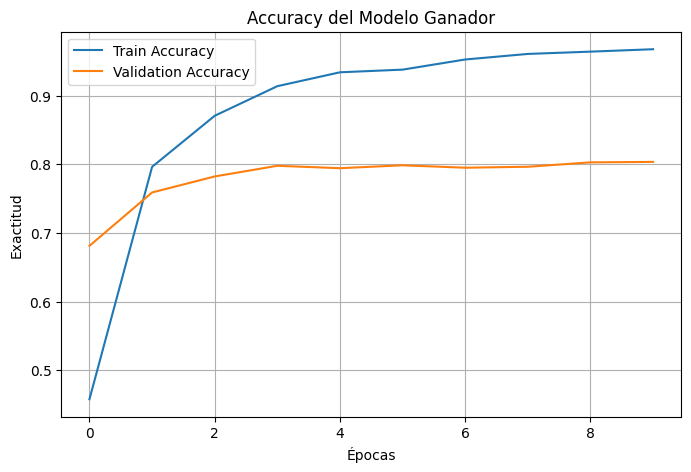

In [ ]:
import matplotlib.pyplot as plt

history = history_D

plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Épocas")
plt.ylabel("Exactitud")
plt.title("Accuracy del Modelo Ganador")
plt.legend()
plt.grid(True)
plt.show()


En la gráfica de loss se observa que la pérdida de entrenamiento baja de 1.9 hasta cerca de 0.25, lo cual muestra que el modelo aprende muy bien a ajustar sus pesos con los datos que ve. Por otro lado, la pérdida de validación también mejora al inicio de 1.3 aprox. a poco más de 1.0, pero después de la época 4 comienza a subir nuevamente y llega hasta valores cercanos a 1.7 en las últimas épocas. Este aumento indica que el modelo deja de mejorar en validación y empieza a sobreajustarse, porque sigue reduciendo el error en entrenamiento pero sin obtener un mejor desempeño en datos nuevos.




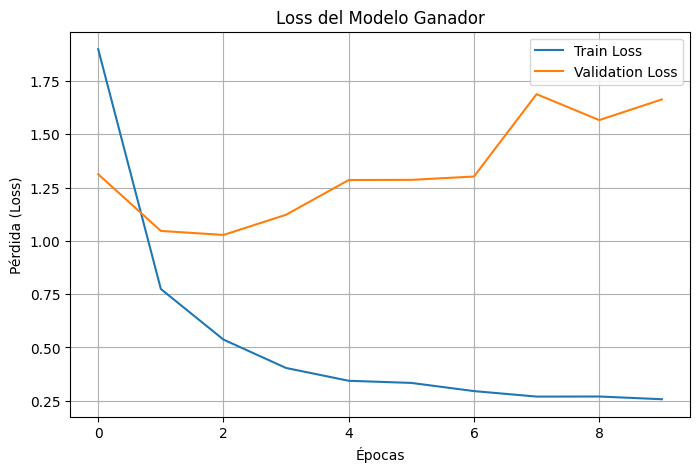

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Épocas")
plt.ylabel("Pérdida (Loss)")
plt.title("Loss del Modelo Ganador")
plt.legend()
plt.grid(True)
plt.show()


Mejor modelo

In [ ]:
from tensorflow.keras import layers, models, regularizers

l2_reg = regularizers.l2(1e-4)

best_model_full = models.Sequential([
    layers.Conv2D(32, (5,5), activation='relu', padding='same',
                  input_shape=(280, 280, 1)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (5,5), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (5,5), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=l2_reg),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax', kernel_regularizer=l2_reg)
])

best_model_full.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = "/content/drive/MyDrive/Proyecto1/Numbers/Train"
TEST_DIR  = "/content/drive/MyDrive/Proyecto1/Numbers/Test"

IMG_SIZE = (280, 280)
BATCH_SIZE = 32

full_train_datagen = ImageDataGenerator(rescale=1./255)

full_train_generator = full_train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True
)

#test
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=1,
    shuffle=False
)

Found 7100 images belonging to 10 classes.
Found 2064 images belonging to 10 classes.


In [ ]:
EPOCHS = 15

history_full = best_model_full.fit(
    full_train_generator,
    epochs=EPOCHS
)


Epoch 1/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 92s 390ms/step - accuracy: 0.3352 - loss: 2.2578
Epoch 2/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 72s 323ms/step - accuracy: 0.8029 - loss: 0.7822
Epoch 3/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 73s 326ms/step - accuracy: 0.8776 - loss: 0.5570
Epoch 4/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 79s 314ms/step - accuracy: 0.9160 - loss: 0.4389
Epoch 5/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 69s 308ms/step - accuracy: 0.9341 - loss: 0.4022
Epoch 6/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 70s 315ms/step - accuracy: 0.9457 - loss: 0.3895
Epoch 7/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 71s 320ms/step - accuracy: 0.9499 - loss: 0.3839
Epoch 8/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 70s 314ms/step - accuracy: 0.9535 - loss: 0.3779
Epoch 9/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 69s 309ms/step - accuracy: 0.9546 - loss: 0.3958
Epoch 10/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 67s 303ms/step - accuracy: 0.9616 - loss: 0.3778
Epoch 11/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 70s 314ms/step - accuracy: 0.9694 - loss: 0.3485
Epoch 12/15
222/222

In [ ]:
test_loss, test_acc = best_model_full.evaluate(test_generator)
print(f"\nAccuracy en TEST: {test_acc:.4f}")

2064/2064 ━━━━━━━━━━━━━━━━━━━━ 808s 391ms/step - accuracy: 0.8998 - loss: 0.6929

Accuracy en TEST: 0.8895


La matriz de confusión muestra que el modelo clasifica correctamente la gran mayoría de los dígitos, con valores altos en la diagonal (entre 177 y 194 aciertos por clase). En general, obtiene una accuracy de 0.89, y los dígitos con mejor desempeño son el 2, 3, 5 y 7, que alcanzan f1-scores cerca a 0.90–0.91. Los errores más comunes aparecen en dígitos que se parecen visualmente, como el 1 con el 4 y el 8 con el 0 o el 5, lo cual también se observa en la matriz.

Al compararlo con la validación del modelo ganador de 0.8035, el modelo fianl ya entrenado con todos los datos mejora su rendimiento, ya que sube a 0.89 en test. Esto nos dice que aprovechar todo el conjunto de entrenamiento le permitió generalizar mejor sin perder estabilidad entre clases.

2064/2064 ━━━━━━━━━━━━━━━━━━━━ 30s 14ms/step

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       204
           1       0.84      0.85      0.85       211
           2       0.90      0.93      0.91       209
           3       0.89      0.92      0.91       207
           4       0.88      0.89      0.89       207
           5       0.93      0.87      0.90       204
           6       0.92      0.87      0.90       208
           7       0.94      0.88      0.91       207
           8       0.85      0.87      0.86       205
           9       0.88      0.89      0.88       202

    accuracy                           0.89      2064
   macro avg       0.89      0.89      0.89      2064
weighted avg       0.89      0.89      0.89      2064



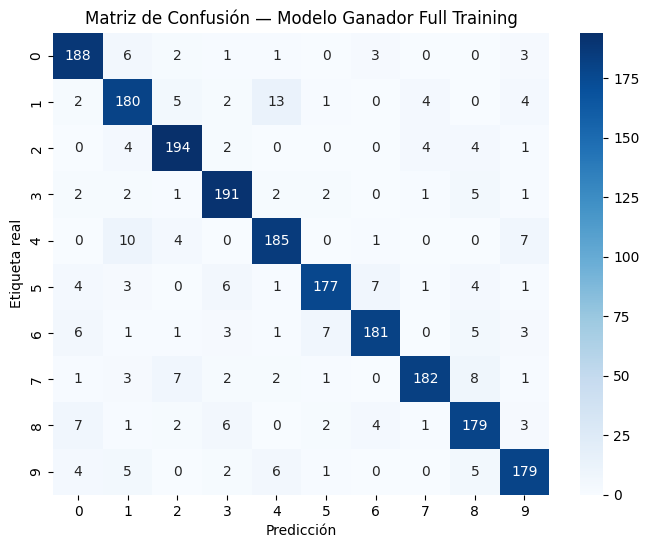

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

#Predicciones
y_true = test_generator.classes
y_pred = np.argmax(best_model_full.predict(test_generator), axis=1)

#Métricas
print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred))

#Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d",
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.title("Matriz de Confusión — Modelo Ganador Full Training")
plt.show()

In [ ]:
#Mejor modelo guardado
best_model_full.save("modelo_ganador.h5")
print("Modelo guardado como modelo_ganador.h5")

Modelo guardado como modelo_ganador.h5
